In [36]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from scipy.interpolate import interpn
from scipy.signal import convolve2d
from tqdm import tqdm

In [41]:
# load images
museum_amb = './data/custom_part2/DSC_1119.JPG'
museum_flash = './data/custom_part2/DSC_1124.JPG'

museum_amb = cv2.imread(museum_amb,-1)[::4,::4,:3][:,:,::-1]
museum_flash = cv2.imread(museum_flash,-1)[::4,::4,:3][:,:,::-1]

# normalize to 0-1
# museum_amb_norm = (museum_amb - np.min(museum_amb)) / (np.max(museum_amb) - np.min(museum_amb))
# museum_flash_norm = (museum_flash - np.min(museum_flash)) / (np.max(museum_flash) - np.min(museum_flash))
museum_amb_norm = museum_amb / 255
museum_flash_norm = museum_flash / 255

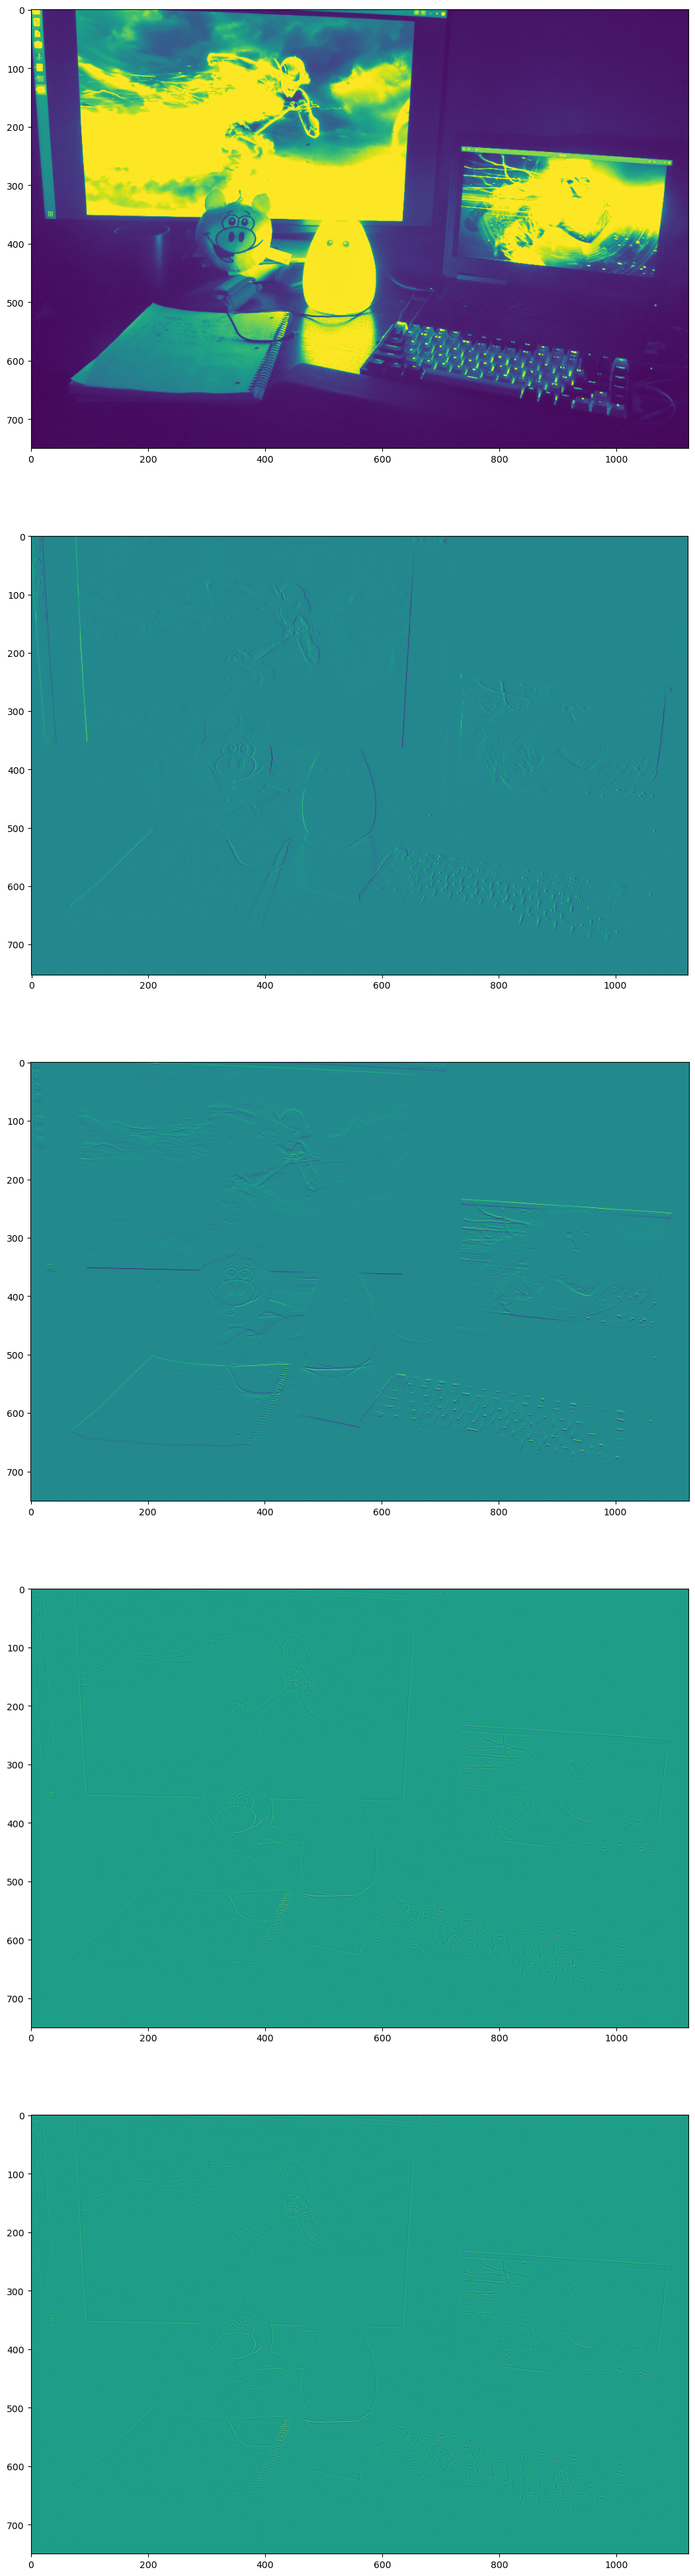

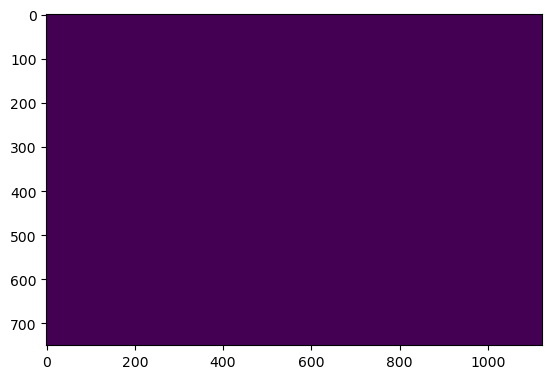

np.allclose(museum_amb_norm_lhs, museum_amb_norm_rhs) =  True


In [42]:
def gradient(img) : 
    
    temp = img[:,:].copy()
    row = np.zeros((1,temp.shape[1]))
    col = np.zeros((temp.shape[0]+2,1))
    temp2 = np.vstack((row,np.vstack((temp, row))))
    temp2 = np.hstack((col,np.hstack((temp2, col))))
    img = temp2.copy() 
    
    # we remove the last row and the last column corresponding to img_x at the end
    # we remove the last col and the last column corresponding to img_y at the end
    
    img_x = np.diff(img,n=1,axis=1) # change along row (i.e. diff bw columns)
    img_y = np.diff(img,n=1,axis=0) # change along column (i.e. diff bw rows) 
#     print(img_x.shape, img_y.shape)
#     img_x, img_y = img_x[:-1,:], img_y[:,:-1]
#     print(img_x.shape, img_y.shape)
    return img_x, img_y # vector field

def divergence(u,v) :
    u_x = np.diff(u,n=1,axis=1) # change along row (i.e. diff bw columns)
    v_y = np.diff(v,n=1,axis=0) # change along column (i.e. diff bw rows)
    u_x, v_y = u_x[1:-1,:], v_y[:,1:-1]
    
    out = u_x + v_y
    return out # scalar field
    
def laplacian(img) :     
    kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    out = convolve2d(img, kernel, mode='same', boundary='fill', fillvalue=0)
    return out # scalar field

# testing functions above

museum_amb_norm_gradient_x,museum_amb_norm_gradient_y  = gradient(museum_amb_norm[:,:,0])
museum_amb_norm_lhs = divergence(museum_amb_norm_gradient_x,museum_amb_norm_gradient_y )
museum_amb_norm_rhs = laplacian(museum_amb_norm[:,:,0])

fig, ax = plt.subplots(5, figsize=(50,50))
ax[0].imshow(museum_amb_norm[:,:,0])
ax[1].imshow(museum_amb_norm_gradient_x)
ax[2].imshow(museum_amb_norm_gradient_y)
ax[3].imshow(museum_amb_norm_lhs)
ax[4].imshow(museum_amb_norm_rhs)
plt.show()
plt.imshow(np.around(museum_amb_norm_lhs,5) == np.around(museum_amb_norm_rhs,5))
plt.show()
print("np.allclose(museum_amb_norm_lhs, museum_amb_norm_rhs) = ",np.allclose(museum_amb_norm_lhs, museum_amb_norm_rhs))

In [43]:
# Differentiate then re-integrate an image

# Poisson Solver

def conjugate_gradient_descent(I_init, B, I_star_boundary, eps, N, D) :
    
    I_star = B * I_init + (1-B) * I_star_boundary
    r = B * (D - laplacian(I_star))
    d = r.copy() 
    delta_new = np.sum(r*r) # <r,r>
    n = 0
    
    while np.sqrt(np.sum(r*r)) > eps and n < N :
        
        if n % 200 == 0 : print(n,np.sqrt(np.sum(r*r)))
        q = laplacian(d)
        eta = delta_new / np.sum(d*q) # n = delta_new / <d,q>
        
        I_star = I_star + B * (eta * d)
        r = B * (r - eta * q)
        
        delta_old = delta_new.copy()
        delta_new = np.sum(r*r)
        
        beta = delta_new / delta_old 
        d = r + beta * d   
    
        n = n + 1
        
    return I_star

def poisson_solver(lap_img, img, N = 1000, eps = 0.001) :
    
    I_init = np.zeros(img.shape)
    
    boundary_size = 1
    B = np.ones(img.shape)
    B[0:boundary_size,:], B[-boundary_size:-1,:], B[:,0:boundary_size], B[:,-boundary_size:-1] = 0,0,0,0
    
    I_star_boundary = np.zeros(img.shape)
    I_star_boundary[0:boundary_size,:] = img[0:boundary_size,:].copy()
    I_star_boundary[-boundary_size:-1,:] = img[-boundary_size:-1,:].copy()
    I_star_boundary[:,0:boundary_size] = img[:,0:boundary_size].copy()
    I_star_boundary[:,-boundary_size:-1] = img[:,-boundary_size:-1].copy()
    
    I_star = conjugate_gradient_descent(I_init, B, I_star_boundary, eps, N, lap_img) 
    
    return I_star


# Laplacian (Divergence of gradient field)

# lap_img_r = laplacian(museum_amb_norm[:,:,0])
# lap_img_g = laplacian(museum_amb_norm[:,:,1])
# lap_img_b = laplacian(museum_amb_norm[:,:,2])

# I_star_r = poisson_solver(lap_img_r, museum_amb_norm[:,:,0])
# I_star_g = poisson_solver(lap_img_g, museum_amb_norm[:,:,1])
# I_star_b = poisson_solver(lap_img_b, museum_amb_norm[:,:,2])

# I_star = np.concatenate((np.expand_dims(I_star_r,2),np.stack((I_star_g,I_star_b),axis=-1)),axis=2)

# fig, ax = plt.subplots(2, figsize = (20,20))

# ax[0].imshow(museum_amb_norm)
# ax[1].imshow(I_star)

# plt.show()


0 87.71563405447806
200 0.27540383716303857
400 0.14339476552424033
600 0.1088444804682345
800 0.05227662648413335
1000 0.023558478429715247
1200 0.009270964534366563
1400 0.0034141242140540997
1600 0.0014526493322330894
1800 0.0004660016009094834
2000 0.00017032084600847514
0 93.55757923155474
200 0.2222456415619081
400 0.10077210463661909
600 0.078063656779425
800 0.0387710691974592
1000 0.017874963848889917
1200 0.006385681140179446
1400 0.0014493129585904682
1600 0.0007220403963743732
1800 0.00027617281680474915
2000 0.00011583084375119784
0 94.15402437290093
200 0.16575488473150932
400 0.08930695920647301
600 0.059843854143883345
800 0.03475090118562529
1000 0.013326611365595717
1200 0.004354141022138507
1400 0.0009887519630030269
1600 0.00036337940710831266
1800 0.00012998077618107522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


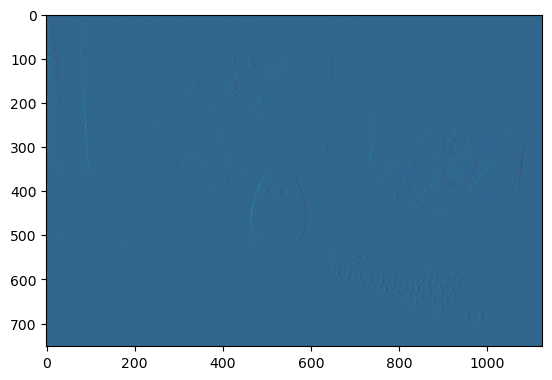

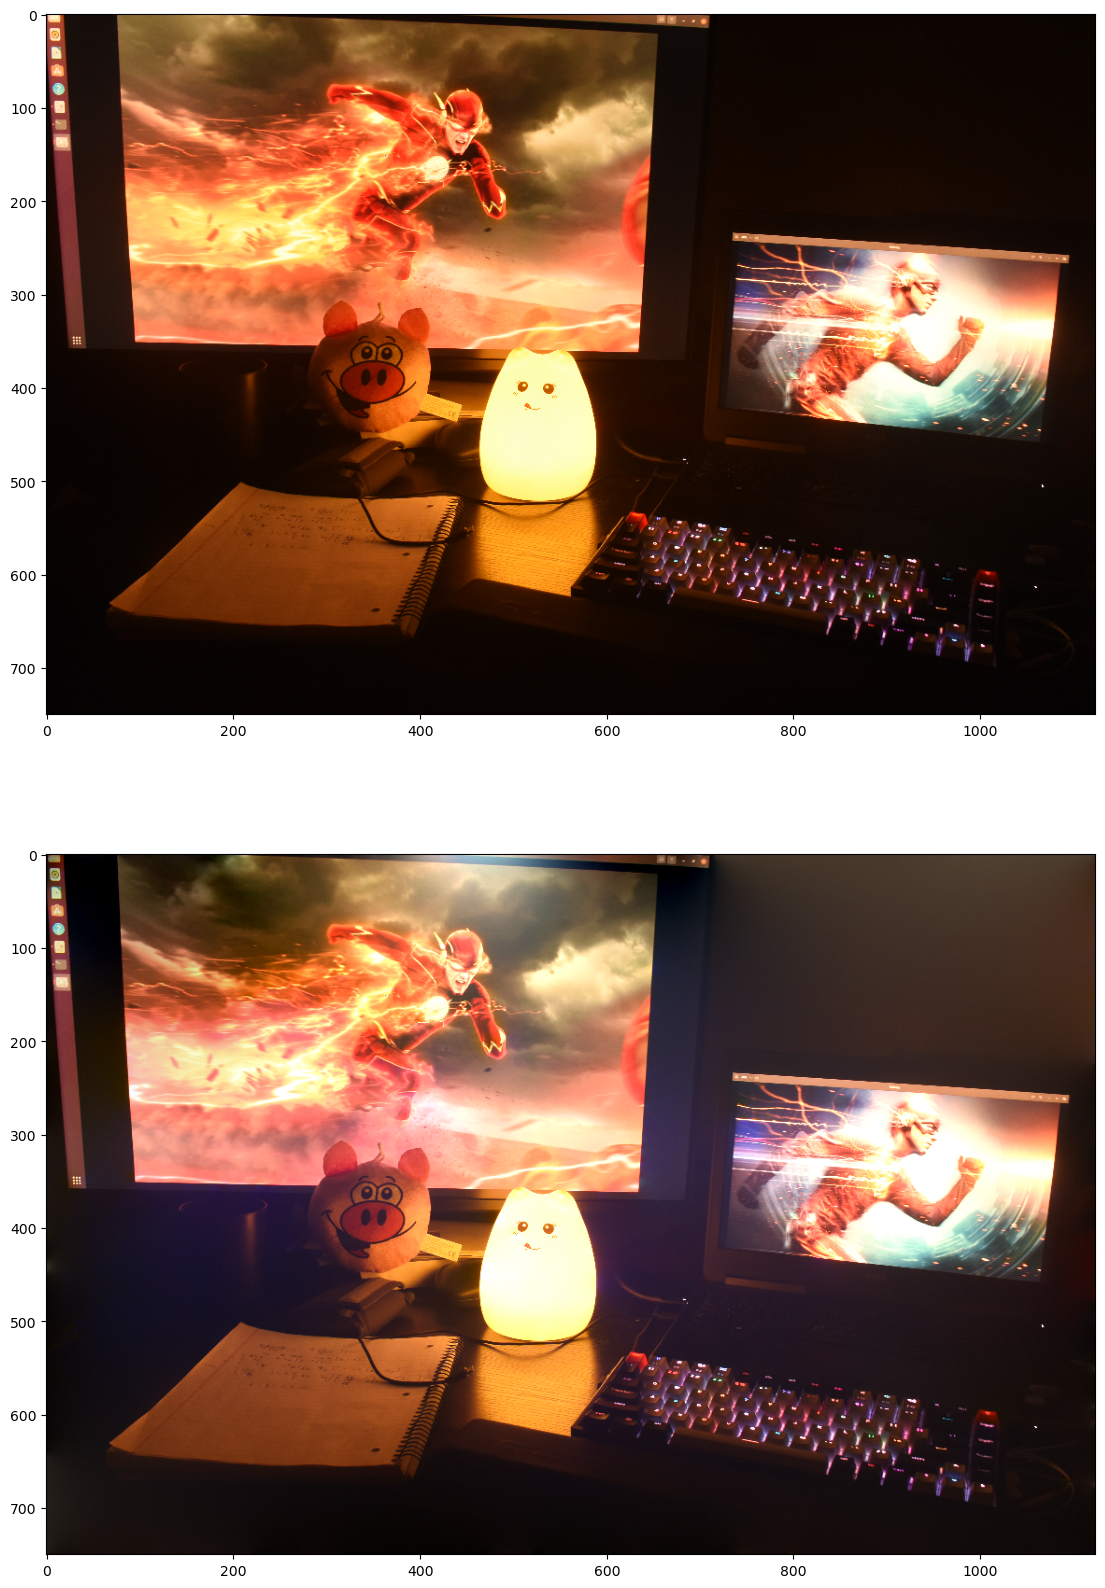

In [44]:
# Creating fused gradient field

def fuse_gradient_field(img_amb_norm, img_flash_norm) : 
    
    a_grad_x, a_grad_y = gradient(img_amb_norm)
    phi_dash_grad_x, phi_dash_grad_y = gradient(img_flash_norm)
    
    a_grad_x_org = a_grad_x.copy()
    a_grad_y_org = a_grad_y.copy()
    phi_dash_grad_x_org = phi_dash_grad_x.copy()
    phi_dash_grad_y_org = phi_dash_grad_y.copy()
    
    a_grad_x, phi_dash_grad_x = a_grad_x[1:,:], phi_dash_grad_x[1:,:]
    a_grad_y, phi_dash_grad_y = a_grad_y[:,1:], phi_dash_grad_y[:,1:]
    
    M_num = phi_dash_grad_x * a_grad_x + phi_dash_grad_y * a_grad_y
    M_den = np.sqrt(phi_dash_grad_x**2 + phi_dash_grad_y**2) * np.sqrt(a_grad_x**2 + a_grad_y**2)
    M = M_num / (M_den+0.00001)
    
    sigma = 200
    tau_s = 0.01
    ws = np.zeros(a_grad_x.shape)
    ws[:-1,:-1] = np.tanh(sigma * (img_flash_norm-tau_s))
    ws = (ws - np.min(ws)) / (np.max(ws) - np.min(ws))
#     print(ws.shape, a_grad_x.shape, M.shape, phi_dash_grad_x.shape, a_grad_y.shape, phi_dash_grad_y.shape)
    phi_star_grad_x = np.zeros(a_grad_x_org.shape)
    phi_star_grad_y = np.zeros(a_grad_y_org.shape)
    phi_star_grad_x[1:,:] = ws * a_grad_x + (1-ws) * (M * phi_dash_grad_x + (1-M) * a_grad_x)
    phi_star_grad_y[:,1:] = ws * a_grad_y + (1-ws) * (M * phi_dash_grad_y + (1-M) * a_grad_y)
    plt.imshow(phi_star_grad_x)
    div = divergence(phi_star_grad_x,phi_star_grad_y)
    
    return div
    
fused_image_r_div = fuse_gradient_field(museum_amb_norm[:,:,0], museum_flash_norm[:,:,0])
fused_image_g_div = fuse_gradient_field(museum_amb_norm[:,:,1], museum_flash_norm[:,:,1])
fused_image_b_div = fuse_gradient_field(museum_amb_norm[:,:,2], museum_flash_norm[:,:,2])

I_star_r = poisson_solver(fused_image_r_div, museum_flash_norm[:,:,0], N=5000, eps=0.0001)
I_star_g = poisson_solver(fused_image_g_div, museum_flash_norm[:,:,1], N=5000, eps=0.0001)
I_star_b = poisson_solver(fused_image_b_div, museum_flash_norm[:,:,2], N=5000, eps=0.0001)

I_star = np.concatenate((np.expand_dims(I_star_r,2),np.stack((I_star_g,I_star_b),axis=-1)),axis=2)

fig, ax = plt.subplots(2, figsize = (20,20))

ax[0].imshow(museum_amb_norm)
ax[1].imshow(I_star)

plt.show()

In [ ]:
plt.imsave('outputs/outputs_report_part3/custom_part2_flashremoved_sigma{}_tau{}_flashinit.png'.format(200,0.01),np.clip(I_star,0,1))

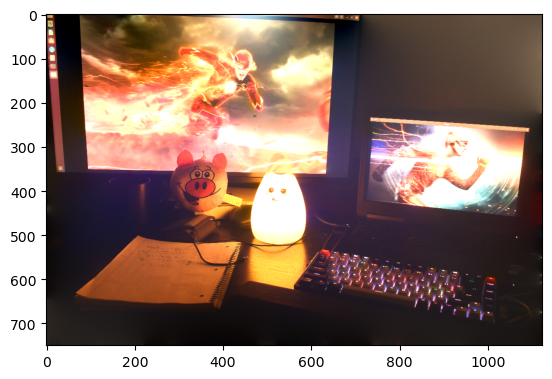

In [22]:
plt.imshow(np.clip(I_star*1.25,0,1))

In [145]:
museum_amb_norm_gradient_x.shape

(640, 906)

In [146]:
museum_amb_norm_gradient_y.shape

(639, 907)